In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import seaborn as sns

In [303]:
import pandas as pd
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')
#remouve nan values
anime = anime.dropna()
rating = rating.dropna()


rating['user_id'] = rating['user_id'].astype(str)
rating['anime_id'] = rating['anime_id'].astype(str)
#changing the type of anime id to string 
anime["anime_id"] = anime["anime_id"].astype(str)

unique_user_ids = list(rating.user_id.unique())
unique_anime_ids = list(anime.anime_id.unique())
unique_genres = list(anime.genre.unique())
unique_types = list(anime.type.unique())
unique_ratings = list(rating.rating.unique())

##normalising the ratings of each user to be between -1 and 1 by subtracting the mean of the ratings of each user and removing the -1
rating['rating'] = rating['rating'].astype(float)
#removing -1 ratings
#ploting the distribution of the ratings with a box plot




rating = rating[rating['rating']!=-1]

#creating a new column for the binary ratings


rating['normalized_rating_1'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean()))

rating['normalized_rating_2'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean())/(x.max()-x.min()))
rating['normalized_rating_3'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean())/(x.std()))


rating['binary_rating'] = rating['rating'].apply(lambda x: 1 if x>=0 else 0)

#renanaming the column rating to anime_rating

anime = anime.rename(columns={'rating':'anime_rating'})

#remouving NAN values
rating = rating.dropna()


In [304]:
rating

,user_id,anime_id,rating,normalized_rating_1,normalized_rating_2,normalized_rating_3,binary_rating
156,3,20,8.0,0.434783,0.062112,0.280517,1
157,3,154,6.0,-1.565217,-0.223602,-1.009861,1
158,3,170,9.0,1.434783,0.204969,0.925706,1
159,3,199,10.0,2.434783,0.347826,1.570895,1
160,3,225,9.0,1.434783,0.204969,0.925706,1
...,...,...,...,...,...,...,...
7813730,73515,13659,8.0,-0.547486,-0.109497,-0.481274,1
7813731,73515,14345,7.0,-1.547486,-0.309497,-1.360336,1
7813732,73515,16512,7.0,-1.547486,-0.309497,-1.360336,1
7813733,73515,17187,9.0,0.452514,0.090503,0.397788,1


In [305]:
anime

,anime_id,name,genre,type,episodes,anime_rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


binary_rating
1    1.0
Name: proportion, dtype: float64


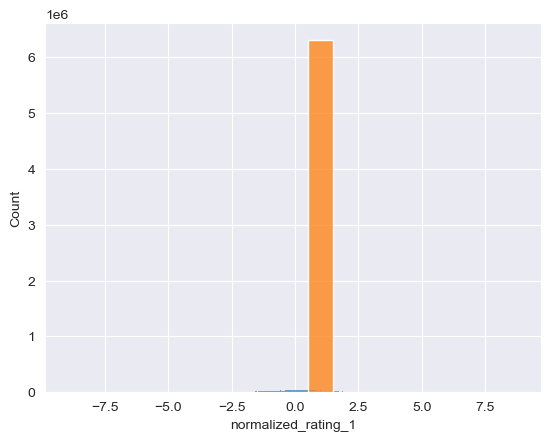

In [306]:
#distribution of binary ratings using a histogram

sns.histplot(x=rating['normalized_rating_1'])


sns.histplot(x=rating['binary_rating'])
#print the percentage of 1 and 0 ratings
print(rating['binary_rating'].value_counts(normalize=True))



<Axes: xlabel='normalized_rating_2', ylabel='Count'>

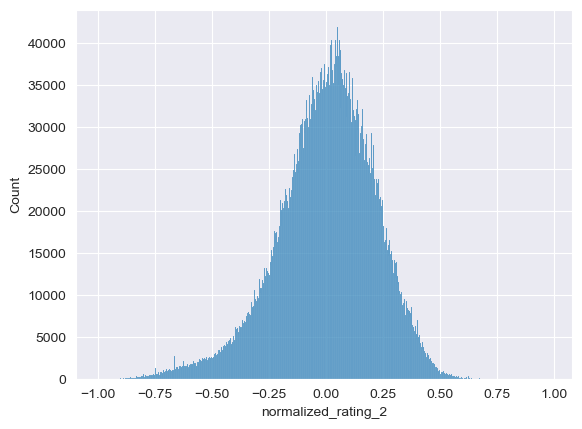

In [256]:
sns.histplot(x=rating['normalized_rating_2'])

<Axes: xlabel='normalized_rating_3', ylabel='Count'>

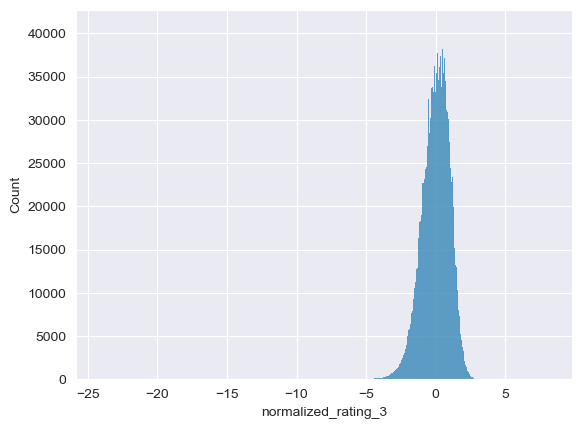

In [257]:
sns.histplot(x=rating['normalized_rating_3'])

<Axes: xlabel='anime_rating'>

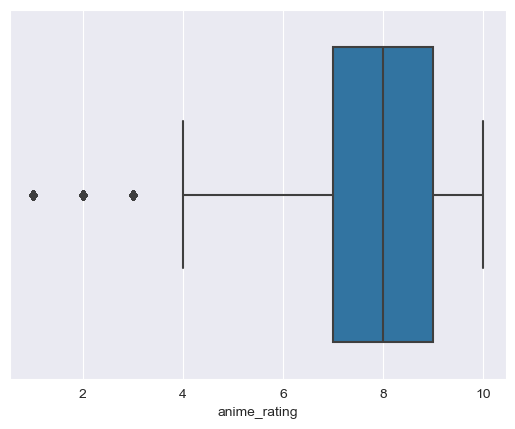

In [286]:
#ploting the distribution of the ratings with a box plot
import seaborn as sns
sns.boxplot(x=rating['anime_rating'])



In [307]:
unique_user_ids = np.unique(unique_user_ids)
unique_anime_ids = np.unique(unique_anime_ids)
unique_genres = np.unique(unique_genres)
unique_types = np.unique(unique_types)


In [310]:
#preaparing the data for the model
columns = ['anime_id','genre',"anime_rating"]

data = rating.merge(anime[columns], on='anime_id')
#dropping the columns that are not needed
print(data)


        user_id anime_id  rating  normalized_rating_1  normalized_rating_2  \
0             3       20     8.0             0.434783             0.062112   
1             5       20     6.0             1.644880             0.182764   
2            21       20     8.0             0.377778             0.047222   
3            28       20     9.0            -0.454545            -0.454545   
4            34       20     9.0             0.285714             0.095238   
...         ...      ...     ...                  ...                  ...   
6304671   69964    23585     7.0            -0.891859            -0.178372   
6304672   69964    33659     6.0            -1.891859            -0.378372   
6304673   72800    30738     4.0            -1.930159            -0.241270   
6304674   73135     8723     5.0            -0.710953            -0.078995   
6304675   73188     8749     6.0            -0.998418            -0.110935   

         normalized_rating_3  binary_rating  \
0               

In [311]:

ratings = tf.data.Dataset.from_tensor_slices(dict(rating))
data = tf.data.Dataset.from_tensor_slices(dict(data))

In [312]:
tf.random.set_seed(42)
shuffled = data.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [361]:
class RankingModel(tf.keras.Model):

  def __init__(self,binary=False):
    super().__init__()
    self.binary = binary
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.anime_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_anime_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_anime_ids) + 1, embedding_dimension)
    ])
    self.genre_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_genres, mask_token=None),
      tf.keras.layers.Embedding(len(unique_genres) + 1, embedding_dimension)
    ])
    """self.type_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_types, mask_token=None),
      tf.keras.layers.Embedding(len(unique_types) + 1, embedding_dimension)
    ])"""

    self.item_importance = tf.keras.Sequential([
      tf.keras.layers.Dense(32, activation="linear"),
      
      
    ])
    """# Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)"""
    # Compute predictions.
    if binary:
      self.ratings = tf.keras.Sequential([
       
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))
      ])
    else:
      self.ratings = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        

        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))
      ])
    
      
  def item_embedding(self, anime_id, genre, type):
    anime_embedding = self.anime_embeddings(anime_id)
    genre_embedding = self.genre_embeddings(genre)
    type_embedding = self.type_embeddings(type)
    return (anime_embedding + genre_embedding + type_embedding) / 3.0

  def call(self, inputs):

    user_id, anime_id, genre,rating = inputs
    
    """user_id=tf.convert_to_tensor(user_id)
    anime_id=tf.convert_to_tensor(anime_id)"""
    
    user_embedding = self.user_embeddings(user_id)
    anime_embedding = self.anime_embeddings(anime_id)
    
    #converting the rating to a tensor
    anime_rating = tf.convert_to_tensor(rating, dtype=tf.float32)
    anime_rating = tf.expand_dims(anime_rating, axis=1)
    print(anime_rating)
    
    genre_embedding = self.genre_embeddings(genre)
    
    #type_embedding = self.type_embeddings(type)

  
    
    item = tf.concat([anime_embedding, genre_embedding], axis=1)
    item = self.item_importance(item)
    
    return self.ratings(tf.concat([user_embedding,item,anime_rating], axis=1))

In [362]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

task_binary = tfrs.tasks.Ranking(
  loss = tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.BinaryAccuracy()]
)


In [363]:
class AnimeModel(tfrs.models.Model):

  def __init__(self,binary=False):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel(binary)
    self.binary = binary
    if binary:
      self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
      )
    else:
      self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["anime_id"], features["genre"], features["anime_rating"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    """labels = features.pop("rating")

    rating_predictions = self(features)
    """
    features = features.copy()  # Make a shallow copy of features
    if self.binary:
      labels = features.pop("binary_rating")
    else:
      labels = features.pop("rating")
        
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
  
    return self.task(labels=labels, predictions=rating_predictions)

    

In [364]:
model = AnimeModel(binary=False)



In [365]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1,clipnorm=0.001))

cached_train = train.shuffle(10_000).batch(8192).cache()
cached_test = test.batch(4096).cache()


In [366]:
two_layer_history = model.fit(cached_train, epochs=500,validation_data=cached_test)

Epoch 1/500
Tensor("ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("ranking_model_34_1/ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("anime_model_34_1/ranking_model_34_1/ExpandDims:0", shape=(None, 1), dtype=float32)


/Users/yassine/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'anime_model_34', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Tensor("anime_model_34_1/ranking_model_34_1/ExpandDims:0", shape=(None, 1), dtype=float32)
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 56.8751 - regularization_loss: 0.6690 - root_mean_squared_error: 7.5207 - total_loss: 57.5441Tensor("anime_model_34_1/ranking_model_34_1/ExpandDims:0", shape=(None, 1), dtype=float32)
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 56.8829 - regularization_loss: 0.6690 - root_mean_squared_error: 7.5245 - total_loss: 57.5519 - val_loss: 57.4606 - val_regularization_loss: 0.6690 - val_root_mean_squared_error: 7.5484 - val_total_loss: 58.1296
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 55.5376 - regularization_loss: 0.6690 - root_mean_squared_error: 7.4357 - total_loss: 56.2066 - val_loss: 56.2325 - val_regularization_loss: 0.6690 - val_root_mean_squared_error: 7.4648 - val_total_loss: 56.9015
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 54.2076 - regularization_loss: 0.6690 - root_mean_squared_error: 7.3469 - total_loss: 

In [367]:

model.evaluate(cached_test, return_dict=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0253 - regularization_loss: 0.5666 - root_mean_squared_error: 1.4269 - total_loss: 2.5919


{'loss': 2.0105345249176025,
 'regularization_loss': 0.5665950179100037,
 'root_mean_squared_error': 1.424301266670227,
 'total_loss': 2.577129602432251}

In [368]:

accuracy = two_layer_history.history
loss = accuracy['loss']

val_loss = accuracy['val_loss']


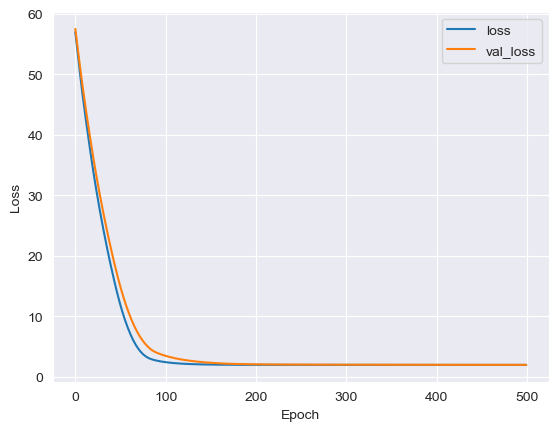

In [369]:
#plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plotting other metrics 


In [370]:
from sklearn.metrics.pairwise import cosine_similarity
#getting the top k movies for a user using similarity model of the embeddings
# Get the embeddings of the animes for the first user in the dataset
user_id = "3"
print(user_id)
user_id = tf.convert_to_tensor([user_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id']) 
user_embedding = model.ranking_model.user_embeddings(user_id)  

# Compute the similarity between user and anime embeddings using cosine similarity 

similarity = cosine_similarity(user_embedding, anime_embeddings)
print(similarity)
similarity = similarity[0]


#similarity = tf.reduce_sum(user_embeddings * anime_embeddings, axis=1)
# Get the top 10 most similar animes

top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})
top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

print(user_id)
print(top_animes)

#cheking how many of the top animes are in the users ratings
top_animes = top_animes.merge(rating[rating["user_id"]=="3"], on='anime_id')
print(top_animes[['anime_id', 'name']]) 

#printing the top 10 users that are similar to the user
unique_user_ids = unique_user_ids
user_embeddings = model.ranking_model.user_embeddings(unique_user_ids)

similarity = cosine_similarity(user_embedding, user_embeddings)


top_users = pd.DataFrame({
    'user_id': unique_user_ids,
    'similarity': similarity[0]
})
top_users = top_users.sort_values(by='similarity', ascending=False).head(2)
print("#############")
print(top_users)
#printing the second uer that is similar to the user

#in order to verify the results we can check the ratings of the second top users and see if they are similar to the user
top_users_2 = top_users.merge(rating[rating["user_id"]==top_users.iloc[1]['user_id']], on='user_id')
print(top_users_2[['user_id', 'rating','anime_id']])
top_users_3 = top_users.merge(rating[rating["user_id"]==top_users.iloc[0]['user_id']], on='user_id')
#intersectting woth top_users_2 and top_users_3 using the anime_id
top_users_4 = top_users_3.merge(top_users_2, on='anime_id')

print(top_users_4)

3
[[-0.20648243  0.17049785  0.02254791 ... -0.03890423  0.13430026
  -0.18936312]]
tf.Tensor([b'3'], shape=(1,), dtype=string)
  anime_id  similarity                                               name  \
0      618    0.661208                Juubee Ninpuuchou: Ryuuhougyoku-hen   
1    26087    0.633418                             Mama Ohanashi Kikasete   
2    31865    0.619677            Kare Baka: Wagahai no Kare wa Baka de R   
3     9241    0.589295               Super Robot Taisen OG: The Inspector   
4    30533    0.575173             Gundam Build Fighters Try: Island Wars   
5     5256    0.568965  Pokemon Fushigi no Dungeon: Toki no Tankentai,...   
6    29099    0.564819                                 Washimo 2nd Season   
7     9887    0.543661                                             Momoko   
8     1357    0.535990                                 Shin Hokuto no Ken   
9     8275    0.533494                            Kanin Tokkyuu Michishio   

                        

In [371]:
import tensorflow as tf
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming `anime` is your DataFrame with anime data
# `model` is your trained model

anime_id = "138"
anime_id_tensor = tf.convert_to_tensor([anime_id])  # Ensure dtype is correct
anime_genre_tensor = tf.convert_to_tensor([anime[anime['anime_id'] == anime_id]['genre'].values[0]])
# Retrieve embeddings
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id'])
anime_embedding = model.ranking_model.anime_embeddings(anime_id_tensor)

genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])
genre_embedding = model.ranking_model.genre_embeddings(anime_genre_tensor)

# Print the name of the anime
print("Anime:", anime[anime['anime_id'] == anime_id]['name'])

# Compute cosine similarity
similarity = cosine_similarity(anime_embedding, anime_embeddings)
similarity = similarity[0]

genre_similarity = cosine_similarity(genre_embedding, genre_embeddings)
genre_similarity = genre_similarity[0]

# Debug: Check shapes and values
print("Anime Embedding Shape:", anime_embedding.shape)
print("Anime Embeddings Shape:", anime_embeddings.shape)
print("Genre Embedding Shape:", genre_embedding.shape)
print("Genre Embeddings Shape:", genre_embeddings.shape)

print("Similarity Scores:", similarity[:10])  # Print first 10 similarity scores
print("Genre Similarity Scores:", genre_similarity[:10])  # Print first 10 genre similarity scores

# Get the top 10 most similar animes
top_anime_genre = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': genre_similarity
})

top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})

top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

top_anime_genre = top_anime_genre.sort_values(by='similarity', ascending=False).head(10)
top_anime_genre = top_anime_genre.merge(anime, on='anime_id')

print("Top Animes based on Embeddings:")
print(top_animes[['anime_id', 'name', 'similarity', 'genre', 'type']])
print("Top Animes based on Genre Similarity:")
print(top_anime_genre[['anime_id', 'name', 'similarity', 'genre', 'type']])
#calculate the similarity of genre_embedding

print(cosine_similarity(genre_embedding, genre_embedding))

Anime: 202    Hunter x Hunter: Greed Island
Name: name, dtype: object
Anime Embedding Shape: (1, 32)
Anime Embeddings Shape: (12017, 32)
Genre Embedding Shape: (1, 32)
Genre Embeddings Shape: (12017, 32)
Similarity Scores: [-0.29307565 -0.43346804 -0.07379377  0.09679805 -0.34153625  0.11301151
  0.1831671  -0.15137938 -0.1200887   0.16002631]
Genre Similarity Scores: [-0.13165295 -0.3147275  -0.30313477  0.01234733 -0.30313477  0.04705282
  0.99999994  0.01624782 -0.30313477 -0.30313477]
Top Animes based on Embeddings:
  anime_id                                               name  similarity  \
0      138                      Hunter x Hunter: Greed Island    1.000000   
1     6460  Crayon Shin-chan Movie 05: Ankoku Tamatama Dai...    0.617397   
2     1825                                   Hadashi no Gen 2    0.585473   
3     4310                       Joshidai: Ecchi Soudanshitsu    0.573507   
4      359                                     I&#039;ll/CKBC    0.569961   
5    17147  

In [372]:
#dong the same but we concatinate the genre and type embeddings to the anime embeddings
anime_id = "138"
anime_id = tf.convert_to_tensor([anime_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id'])
anime_embedding = model.ranking_model.anime_embeddings(anime_id)

anime_genre_tensor = tf.convert_to_tensor([anime[anime['anime_id'] == anime_id]['genre'].values[0]])

genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])
genre_embedding = model.ranking_model.genre_embeddings(anime_genre_tensor)


#concatinating the embeddings
"""anime_embedding = tf.concat([anime_embedding*2.0,genre_embedding], axis=1)
anime_embeddings = tf.concat([anime_embeddings*2.0,genre_embeddings], axis=1)"""

item = tf.concat([anime_embedding, genre_embedding], axis=1)
item = model.ranking_model.item_importance(item)

items = tf.concat([anime_embeddings, genre_embeddings], axis=1)
items = model.ranking_model.item_importance(items)

# Compute the similarity between user and anime embeddings
"""
similarity = tf.reduce_sum(anime_embedding * anime_embeddings, axis=1)
similarity_based_on_item = tf.reduce_sum(item * items, axis=1)  """

#calulating the similatiry based on cosine similarity
similarity = cosine_similarity(anime_embedding, anime_embeddings)
similarity = similarity[0]

similarity_based_on_item = cosine_similarity(item, items)
similarity_based_on_item = similarity_based_on_item[0]



# Get the top 10 most similar animes

top_items = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity_based_on_item
})

top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})

top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

top_items = top_items.sort_values(by='similarity', ascending=False).head(10)
top_items = top_items.merge(anime, on='anime_id')

#print(top_animes[['anime_id', 'name','similarity', 'genre' , 'type' ]])

print(top_items[['anime_id', 'name','similarity', 'genre' , 'type' ]])


  anime_id                                               name  similarity  \
0      138                      Hunter x Hunter: Greed Island    1.000000   
1    10189                              Hunter x Hunter Pilot    0.967277   
2    10790                Kore wa Zombie Desu ka? of the Dead    0.964716   
3      139                Hunter x Hunter: Greed Island Final    0.964392   
4     5636                        RESTOL: Special Rescue Team    0.962559   
5     2182                                     Robot Carnival    0.962413   
6    23259                           Gundam: G no Reconguista    0.962175   
7     6288  Mobile Suit Gundam 00 The Movie: A Wakening of...    0.961491   
8    25859                                            Re-Kan!    0.960704   
9      146                  Kono Minikuku mo Utsukushii Sekai    0.959880   

                                               genre   type  
0            Action, Adventure, Shounen, Super Power    OVA  
1            Action, Adventu

In [375]:
from sklearn.metrics.pairwise import cosine_similarity
#getting the top k movies for a user using similarity model of the embeddings
# Get the embeddings of the animes for the first user in the dataset
user_id = "3"
print(user_id)
user_id = tf.convert_to_tensor([user_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id']) 
user_embedding = model.ranking_model.user_embeddings(user_id)  
genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])

items = tf.concat([anime_embeddings, genre_embeddings], axis=1)
items = model.ranking_model.item_importance(items)

# Compute the similarity between user and anime embeddings using cosine similarity 

similarity = cosine_similarity(user_embedding, items)
print(similarity)
similarity = similarity[0]

#printing the top 10 most similar animes to the user with the ratings if exits 

top_anime = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})

top_anime = top_anime.sort_values(by='similarity', ascending=False).head(1000)
#merging the top animes with the ratings of the user with constraint that the user id is 3

top_anime = top_anime.merge(rating[rating['user_id']=="3"], on='anime_id')

print(top_anime)

3
[[0.08110912 0.03371719 0.1809056  ... 0.11617517 0.04928163 0.10530773]]
  anime_id  similarity user_id  rating  normalized_rating_1  \
0    11703    0.240279       3     6.0            -1.565217   
1    16498    0.223355       3    10.0             2.434783   
2    28223    0.216684       3     6.0            -1.565217   
3     9919    0.215185       3     8.0             0.434783   
4     6880    0.205799       3     6.0            -1.565217   

   normalized_rating_2  normalized_rating_3  binary_rating  
0            -0.223602            -1.009861              1  
1             0.347826             1.570895              1  
2            -0.223602            -1.009861              1  
3             0.062112             0.280517              1  
4            -0.223602            -1.009861              1  


12018
73516


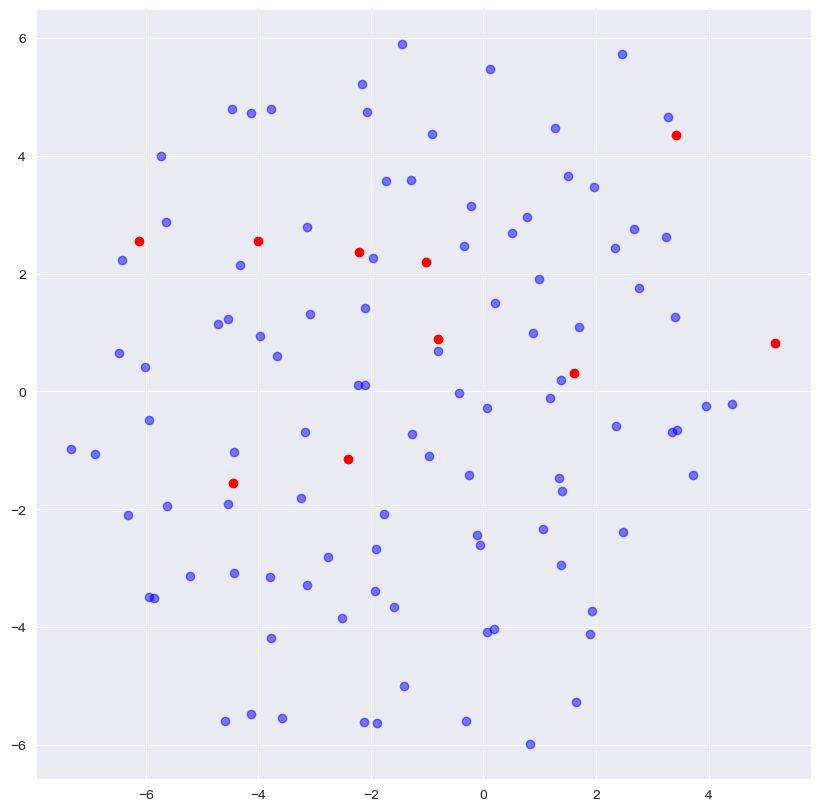

In [274]:
#using tsne to visualise the embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings
user_embeddings = model.ranking_model.user_embeddings.get_weights()[0]
anime_embeddings = model.ranking_model.anime_embeddings.get_weights()[0]
print(len(anime_embeddings))
print(len(user_embeddings))
# Take the first 1000 most popular anime
popular_anime = anime['anime_id'].value_counts().index[:100]
#popular_anime_embeddings = anime_embeddings[popular_anime]

#popular_anime_embeddings = anime_embeddings[:100]
users = user_embeddings[:10]

popular_anime_embeddings = model.ranking_model.anime_embeddings(popular_anime)
#users = model.ranking_model.user_embeddings(users)

data = np.concatenate([users, popular_anime_embeddings], axis=0)
# Reduce dimensionality to 2D
tsne = TSNE()
tsne_transformed = tsne.fit_transform(data)

# Separate user and anime embeddings
user_tsne = tsne_transformed[:len(users)]
anime_tsne = tsne_transformed[len(users):]

# Plot user and anime embeddings
plt.figure(figsize=(10, 10))
plt.scatter(user_tsne[:, 0], user_tsne[:, 1], color='red')
plt.scatter(anime_tsne[:, 0], anime_tsne[:, 1], color='blue', alpha=0.5)
plt.show()


In [98]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict, Text

class RankingModel(tf.keras.Model):
    def __init__(self, unique_user_ids, unique_anime_ids, unique_genres, embedding_dimension=32):
        super().__init__()
        self.embedding_dimension = embedding_dimension

        # User embeddings
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, self.embedding_dimension)
        ])

        # Anime embeddings
        self.anime_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_anime_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_anime_ids) + 1, self.embedding_dimension)
        ])

        # Genre embeddings
        self.genre_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_genres, mask_token=None),
            tf.keras.layers.Embedding(len(unique_genres) + 1, self.embedding_dimension)
        ])

        # Dense layers for combining embeddings
        self.combine_embeddings = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))  # Binary classification
        ])

    def call(self, inputs):
        user_id, anime_id, genre = inputs

        # Get embeddings
        user_embedding = self.user_embeddings(user_id)
        anime_embedding = self.anime_embeddings(anime_id)
        genre_embedding = self.genre_embeddings(genre)

        # Combine embeddings
        combined_embeddings = tf.concat([user_embedding, anime_embedding, genre_embedding], axis=1)

        # Pass through dense layers
        return self.combine_embeddings(combined_embeddings)

class AnimeModel(tfrs.models.Model):
    def __init__(self, unique_user_ids, unique_anime_ids, unique_genres, binary=False):
        super().__init__()
        self.ranking_model = RankingModel(unique_user_ids, unique_anime_ids, unique_genres)
        self.binary = binary
        if binary:
            self.task = tfrs.tasks.Ranking(
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy()]
            )
        else:
            self.task = tfrs.tasks.Ranking(
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()]
            )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_id"], features["anime_id"], features["genre"])
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        features = features.copy()  # Make a shallow copy of features
        if self.binary:
            labels = features.pop("binary_rating")
        else:
            labels = features.pop("rating")

        rating_predictions = self(features)

        # The task computes the loss and the metrics.
        return self.task(labels=labels, predictions=rating_predictions)

# Example usage:
# unique_user_ids = ['user1', 'user2', ...]
# unique_anime_ids = ['anime1', 'anime2', ...]
# unique_genres = ['genre1', 'genre2', ...]
# model = AnimeModel(unique_user_ids, unique_anime_ids, unique_genres, binary=True or False)


In [99]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,clipnorm=0.001))

# Early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=5, verbose=1)

# Train the model
history = model.fit(cached_train, epochs=100, validation_data=cached_test,callbacks=[lr_scheduler])


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - binary_accuracy: 0.8201 - loss: 1.6570 - regularization_loss: 0.0072 - total_loss: 1.6642 - val_binary_accuracy: 0.6192 - val_loss: 2.3971 - val_regularization_loss: 0.0130 - val_total_loss: 2.4100 - learning_rate: 0.0100
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.8870 - loss: 0.2871 - regularization_loss: 0.0189 - total_loss: 0.3060 - val_binary_accuracy: 0.5850 - val_loss: 1.9602 - val_regularization_loss: 0.0251 - val_total_loss: 1.9853 - learning_rate: 0.0100
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.9742 - loss: 0.0720 - regularization_loss: 0.0298 - total_loss: 0.1018 - val_binary_accuracy: 0.6011 - val_loss: 1.7836 - val_regularization_loss: 0.0332 - val_total_loss: 1.8168 - learning_rate: 0.0100
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9937 - loss: 0.0271 - regularization_loss: 0.0303 - total_loss: 0.0574 - val_binary_accuracy: 0.599

In [111]:
import numpy as np
from sklearn.model_selection import KFold

def dataset_to_numpy(dataset):
    user_ids, anime_ids, genres, labels = [], [], [], []
    for element in dataset:
        user_ids.append(element['user_id'].numpy())
        anime_ids.append(element['anime_id'].numpy())
        genres.append(element['genre'].numpy())
        if 'binary_rating' in element:
            labels.append(element['binary_rating'].numpy())
        else:
            labels.append(element['rating'].numpy())
    return np.array(user_ids), np.array(anime_ids), np.array(genres), np.array(labels)

# Cross-validation function
def cross_val_score(model_class, train_dataset, unique_user_ids, unique_anime_ids, unique_genres, binary, k=5):
    # Convert tf.data.Dataset to numpy arrays
    user_ids, anime_ids, genres, labels = dataset_to_numpy(train_dataset)
    
    kfold = KFold(n_splits=k, shuffle=True)
    val_scores = []
    print("HAYA")
    for train_index, val_index in kfold.split(user_ids):
        train_data = tf.data.Dataset.from_tensor_slices(
            {"user_id": user_ids[train_index], "anime_id": anime_ids[train_index], "genre": genres[train_index], "binary_rating" if binary else "rating": labels[train_index]}
        ).batch(32)
        val_data = tf.data.Dataset.from_tensor_slices(
            {"user_id": user_ids[val_index], "anime_id": anime_ids[val_index], "genre": genres[val_index], "binary_rating" if binary else "rating": labels[val_index]}
        ).batch(32)

        model = model_class(unique_user_ids, unique_anime_ids, unique_genres, binary)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
        model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[ lr_scheduler])

        val_score = model.evaluate(val_data)
        val_scores.append(val_score)
        

    return np.mean(val_scores), np.std(val_scores)

# Perform cross-validation
mean_val_score, std_val_score = cross_val_score(AnimeModel, data, unique_user_ids, unique_anime_ids, unique_genres, binary=True)
print(f'Mean validation score: {mean_val_score}, Standard deviation: {std_val_score}')



KeyboardInterrupt: 

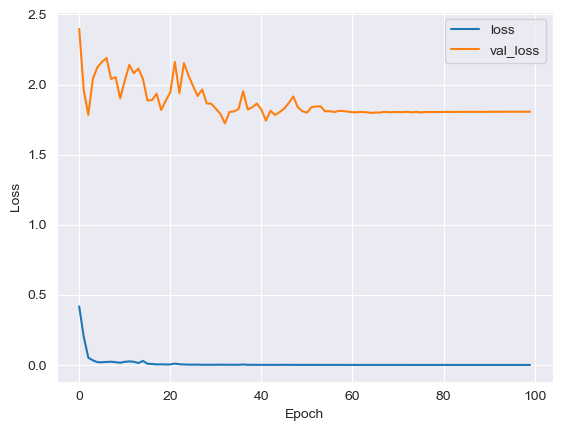

In [100]:
#plotting the loss and acuuracy 
accuracy = history.history
loss = accuracy['loss']
val_loss = accuracy['val_loss']

#plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [75]:
#plotting the accuracy
accuracy = history.history
accuracy = accuracy['binary_accuracy']
val_accuracy = accuracy['val_binary_accuracy']

#plotting the loss
import matplotlib.pyplot as plt
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

TypeError: list indices must be integers or slices, not str

In [82]:
#cheking the top 10 similar anime to a given anime
anime_id = "138"
anime_id = tf.convert_to_tensor([anime_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id'])
anime_embedding = model.ranking_model.anime_embeddings(anime_id)

genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])
genre_embedding = model.ranking_model.genre_embeddings(anime_id)



# Compute the similarity between user and anime embeddings
"""similarity = tf.reduce_sum(anime_embedding * anime_embeddings, axis=1)
genre_simolarity = tf.reduce_sum(genre_embedding * genre_embeddings, axis=1)
"""

similarity = cosine_similarity(anime_embedding, anime_embeddings)
similarity = similarity[0]

genre_simolarity = cosine_similarity(genre_embedding, genre_embeddings)
genre_simolarity = genre_simolarity[0]


#using the eclidian  distance metric to get the top 10 most similar 
"""similarity = tf.norm(anime_embedding - anime_embeddings, axis=1)
genre_simolarity = tf.norm(genre_embedding - genre_embeddings, axis=1)

"""


# Get the top 10 most similar animes

top_anime_genre = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': genre_simolarity
})


top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})

top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

top_anime_genre = top_anime_genre.sort_values(by='similarity', ascending=False).head(10)
top_anime_genre = top_anime_genre.merge(anime, on='anime_id')


print(top_animes[['anime_id', 'name','similarity', 'genre' , 'type' ]])
print(top_anime_genre[['anime_id', 'name','similarity', 'genre' , 'type' ]])


  anime_id                                               name  similarity  \
0      138                      Hunter x Hunter: Greed Island    1.000000   
1    32904                   Norimono Atsumare: Hit Song-shuu    0.648553   
2    17106                   Wala! Pyeon-uijeom The Animation    0.609210   
3     1148                                   Teito Monogatari    0.605255   
4    31145  Code Geass: Boukoku no Akito 3 - Kagayaku Mono...    0.578710   
5    12139                                  Wanpaku Tanteidan    0.577878   
6     7511                                              Worku    0.565910   
7    12343                                 Dirty Pair Flash 2    0.552436   
8    27677            Stratos 4 OVA: Stratos 4.1 - Dutch Roll    0.546990   
9    22461                        Hello Kitty no Yume Dorobou    0.544776   

                                              genre     type  
0           Action, Adventure, Shounen, Super Power      OVA  
1                         